In [2]:
#import necessary libraries
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt
# for better 3D-Visualisation
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats
from sklearn.metrics import silhouette_score
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

sns.set_theme(style="ticks", color_codes=True)

# Aim
The aim of this project to divide our customers into several homogeneous groups. This allows the marketing department to address the different target groups more efficiently. We will perform a clustering based on RFM (Recency, Frequency, Monetary value). Frequency and monetary value are an indicator for the customer’s lifetime value, whereas recency shows the engagement of the customer.

## Data
The dataset is from kaggle: https://www.kaggle.com/vijayuv/onlineretail. It includes information such as Invoice Number, Invoice Date, Customer Id, Selling price and quantity.
Features:
* InvoiceNo: Invoice Number assigned to each order. If this code starts with letter 'c', it indicates a cancellation.
* StockCode: Product (item) code assigned to each product.
* Description: Product name.
* Quantity: Amount of each each product (item) per transaction.
* InvoiceDate: Date, where order was made. 
* UnitPrice: Price of a single product.
* CustomerID: Customer number assigned to each customer.
* Country: Country, where each customer resides.


# Import data

In [3]:
df = pd.read_csv('Clustering_Marketing.csv', delimiter=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## First look into the data
The data contains 541909 rows. Each row stands for one product of an order. Orders can be grouped by the InvoiceNo. As we can already see there are less entries in the CustomerID column which indicates that there are missing values.

In [4]:
#first look into the data
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
#number of unique values of each column
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


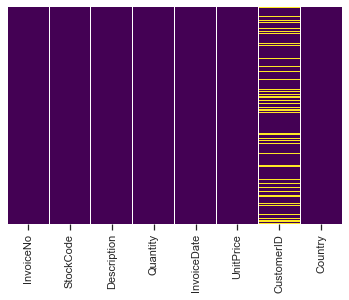

In [7]:
#check missing values
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis');

In [8]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## Initial findings
The data contains information about 25900 orders, which were made by 4372 customers from 38 different countries. Also the dataset includes 4070 different products. The average price of a product is 4.61 €. <br></br>
**Needs further investigation:**
* There are probably some mistakes in the data as there are negative values for UnitPrice and Quantity.
* Min and max of Quantity is 80995, which also indicates an error or data reversal.
* The negative min of unit price could indicate cancellations of orders as negative prices are not common for products.
* The missing values in the CustomerID column are a problem as customers must be clearly identified to assign them to one customer segment.

# Data Preparation

## Invoice Date
We will change the datatype for InvoiceDate to enable further feature engineering.

In [9]:
#change data type
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

## InvoiceNo
Invoice-Numbers with "C" and "A" as a first character are assigned to cancelled orders (cancelled by customer) and bad dept adjustments (cancelled by company). As those order types don't reflect the actual customer's purchase behavior, we will exclude those incomplete orders from our segmentation and drop those rows.

In [10]:
#change datatype
df['InvoiceNo']=df['InvoiceNo'].astype('category')

# Select rows with an C or A in the beginning of the InvoiceNo
df_cancelled=df[df['InvoiceNo'].str[0].isin(['A', 'C'])]
df_cancelled.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [11]:
# Remove rows
df=df[~df.InvoiceNo.isin(df_cancelled.InvoiceNo)]

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [12]:
#Check
df[df['InvoiceNo'].str[0].isin(['c', 'C'])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


## Stock Code and Decscription
As those columns are less relevant for our RFM-analysis, we will only change the datatypes for now.

In [13]:
#Change datatype
df['StockCode']=df['StockCode'].astype('category')
df['Description']=df['Description'].astype('category')

## Unit Price
As the unit price only represents the price of a single product we need to calculate the total sum of each product per order by multiplicating the unit price and the amount bought.

In [14]:
df['TotalSum'] = df['Quantity'] * df['UnitPrice']
df.describe()

,Quantity,UnitPrice,CustomerID,TotalSum
count,532618.000000,532618.000000,397924.000000,532618.000000
mean,10.240024,3.868412,15294.315171,20.006125
std,159.593999,32.470442,1713.169877,269.296764
min,-9600.000000,0.000000,12346.000000,-0.000000
25%,1.000000,1.250000,13969.000000,3.750000
50%,3.000000,2.080000,15159.000000,9.900000
75%,10.000000,4.130000,16795.000000,17.700000
max,80995.000000,13541.330000,18287.000000,168469.600000


In [15]:
# View rows with 0 TotalSum or 0 UnitPrice
df[df['TotalSum']==0].count()

df[df['TotalSum']==0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom,0.0
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom,0.0
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,0.0
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,0.0
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom,0.0


There are 2515 rows with 0 as UnitPrice. This could be due to returns or data problems. We will drop these rows for our further analysis.

In [16]:
# Remove rows
df=df[~df.TotalSum.isin([0])]

#check
df[df.TotalSum.isin([0])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum


## Customer ID and Country
As already mentioned, there are about 25% missing values in the CustomerID column. Without the CustomerID it is impossible to assign it to a specific cluster. Those missing values could be a result from a guest checkout. Guest checkout is mainly used for customers, who don't buy frequently on the shop and may represent one-time purchases. However, we could not clarify those assumptions in this project. Therefore, we decide to drop those rows so that they do not falsify our result.<br></br>
The country column is also less relevant for our RFM-analysis. Therefore, we will only change the datatype for now.

In [17]:
# Identify rows with missing customerID
df.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132219
Country             0
TotalSum            0
dtype: int64

In [18]:
df[df['CustomerID'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom,2.51
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,5.02
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom,3.40
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom,3.32
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom,14.94
...,...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom,20.65
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom,16.52
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom,4.96
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom,10.79


In [19]:
#Drop rows with missing values
df=df[~df.CustomerID.isnull()]

#check
df[df.CustomerID.isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum


In [20]:
##Change Datatypes
df['CustomerID']=df['CustomerID'].astype('int64').astype('category')
df['Country']=df['Country'].astype('category')

# Create dataset for RFM-Segmentation
In order to identify most relevant customers and other customer segments, we will cluster the customers based on RFM. It takes into account how current a customer is (Recency) and how often (Frequency) and much (Monetary Value) they buy. 
* Receny: days since last purchase of each customer
* Frequency: Total number of orders per customer
* Monetary Value: Total amount spent by customer

## Calculation RFM-Features

In [21]:
# Preparation Attribute : Monetary Value
df['UnitPrice_total']=df['UnitPrice']* df['Quantity']

#Preparation Attribute: Recency
end_date=df['InvoiceDate'].max() + dt.timedelta(days=1)

#Aggregation of data according to RFM
df_rfm = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (end_date - x.max()).days, #days since last order
    'InvoiceNo':  'count', #total number of orders of a customer
    'UnitPrice_total': 'sum'}) #total money spent by a customer

#Rename Columns
df_rfm=df_rfm.rename(columns={'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'UnitPrice_total': 'Monetary'})

In [22]:
df_rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,182,4310.00
12348,75,31,1797.24
12349,19,73,1757.55
12350,310,17,334.40


# Data Exploration before Clustering
Before starting with the clustering we will take a closer look at our dataset. <br></br>
* Some customer have bought just recently whereas the last purchase of another customer is more than a year ago. The average time between today and the last purchase of a customer is 92 days.
* All customers have at least bought 1 time. The great difference between the third quantile and the maximum indicates an outlier in the frequency column. It is unrealistic that a customer placed 7847 orders in approximately one year.
* The minimum amount spent by a customer is 3.75€ and the maximum is 280206 €, which indicates a heavy user or another data error.

In [23]:
df_rfm.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,91.720609,2054.266460
std,100.014169,228.785094,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,307.415000
50%,51.000000,41.000000,674.485000
75%,142.000000,100.000000,1661.740000
max,374.000000,7847.000000,280206.020000


## Drop outliers
kMeans is very sensitive regarding outliers. Therefore, we should take a closer look at the high deviations and verify their authenticity. We define outliers as value, which are more than 3 standard deviations away from the mean.

In [24]:
# Z-Score describes how many standard deviations a value is away from the mean
z_scores = stats.zscore(df_rfm)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_rfm[~filtered_entries]

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12415,24,714,124914.53
12748,1,4595,33719.73
12931,22,82,42055.96
13081,12,1024,28337.38
13089,3,1818,58825.83
13263,1,1677,7454.07
13694,4,568,65039.62
13798,1,349,37153.85


The outliers mainly result from Frequency and Monetary value. The Frequency has very high values. It is unrealistic, that a customer really ordered 7847 times during one year.The average Monetary value of these customers is very high. <br></br>
In a real project, we would have to talk again to the data owners. For our further procedure, we will remove these outliers, as we fear, that they would distort the result.

In [25]:
df_rfm=df_rfm[filtered_entries]

# Data Pre-Processing before Clustering

## Check distribution of the columns

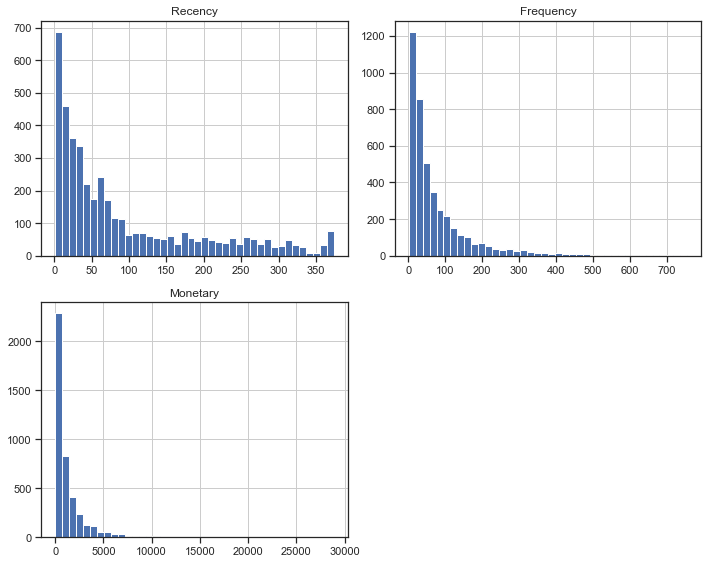

In [26]:
df_rfm.hist(figsize=(10,8), bins=40)
plt.tight_layout();

The distribution of the variables are not symmetrical as we have extreme values on the right side of the distribution even though we removed the outliers. Furthermore, the three columns have different ranges and units. Therefore, further data preprocessing is needed for kMeans Clustering.

# Clustering with kMeans
## Data Cleaning before Clustering
kMeans expects symmetrical data. Therefore, we need to log (normalize data) and standardize the data before the segmentation.
### Normalize data
Goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.

In [27]:
# Copy original to new df
df_rfm_log = df_rfm.copy()

# Transform skewed data with log transformation
df_rfm_log = np.log(df_rfm_log)

df_rfm_log.describe()

,Recency,Frequency,Monetary
count,4288.000000,4288.000000,4288.000000
mean,3.791201,3.650075,6.547977
std,1.415382,1.289776,1.196777
min,0.000000,0.000000,1.321756
25%,2.890372,2.833213,5.722661
50%,3.951244,3.713572,6.495998
75%,4.969813,4.584967,7.381083
max,5.924256,6.628041,10.270989


,Recency,Frequency,Monetary
count,4288.000000,4288.000000,4288.000000
mean,3.791201,3.650075,6.547977
std,1.415382,1.289776,1.196777
min,0.000000,0.000000,1.321756
25%,2.890372,2.833213,5.722661
50%,3.951244,3.713572,6.495998
75%,4.969813,4.584967,7.381083
max,5.924256,6.628041,10.270989


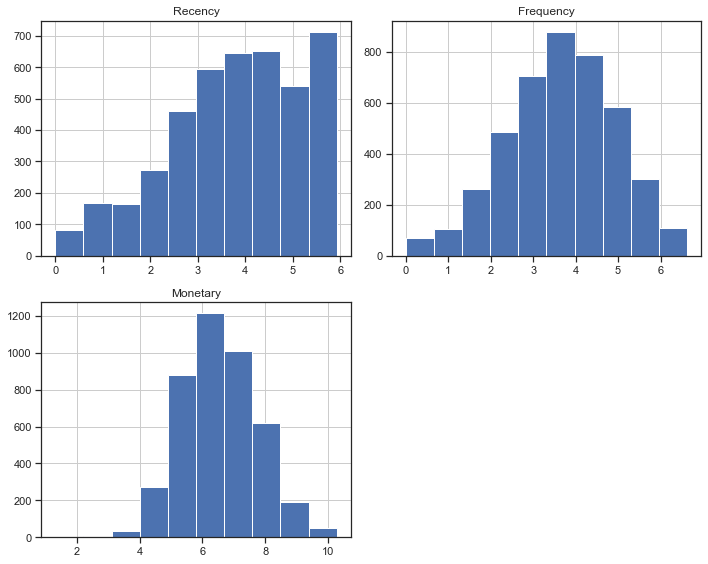

In [28]:
# Plot df_rfm_log again
df_rfm_log.hist(figsize=(10,8))
plt.tight_layout();
df_rfm_log.describe()

### Standardize data
Standardizing is important when working with variables with different units. Variables that are measured at different scales do not contribute equally to the analysis. Therefore, standardization distributes the feature around the center 0 with a standard deviation of 1.

In [29]:
# Instantiate
scaler = StandardScaler()

# fit_transform
df_rfm_scaled = scaler.fit_transform(df_rfm_log)

#transform to dataframe
df_rfm_scaled = pd.DataFrame(df_rfm_log)
df_rfm_scaled.columns = ['Recency', 'Frequency', 'Monetary']
df_rfm_scaled.describe()

,Recency,Frequency,Monetary
count,4288.000000,4288.000000,4288.000000
mean,3.791201,3.650075,6.547977
std,1.415382,1.289776,1.196777
min,0.000000,0.000000,1.321756
25%,2.890372,2.833213,5.722661
50%,3.951244,3.713572,6.495998
75%,4.969813,4.584967,7.381083
max,5.924256,6.628041,10.270989


<AxesSubplot:>

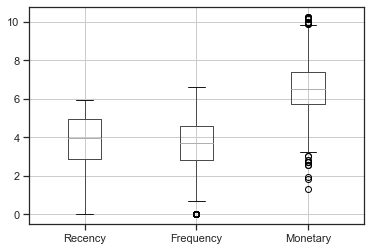

In [30]:
df_rfm_scaled.boxplot()

## Find perfect number of k with silhouette Analysis
The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. Silhouette coefficients near +1 indicate that the sample is far away from the neighboring clusters whereas coefficients near 0 indicate that the sample is near to another cluster.

In [31]:
#import necessary libraries
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [32]:
# Save features as array
X=df_rfm_scaled[['Recency', 'Frequency', 'Monetary']].to_numpy()

For n_clusters = 2 The average silhouette_score is : 0.39263058089228414
For n_clusters = 3 The average silhouette_score is : 0.29944059978136534
For n_clusters = 4 The average silhouette_score is : 0.30790845429646163
For n_clusters = 5 The average silhouette_score is : 0.2867897097214199
For n_clusters = 6 The average silhouette_score is : 0.28213750961488054


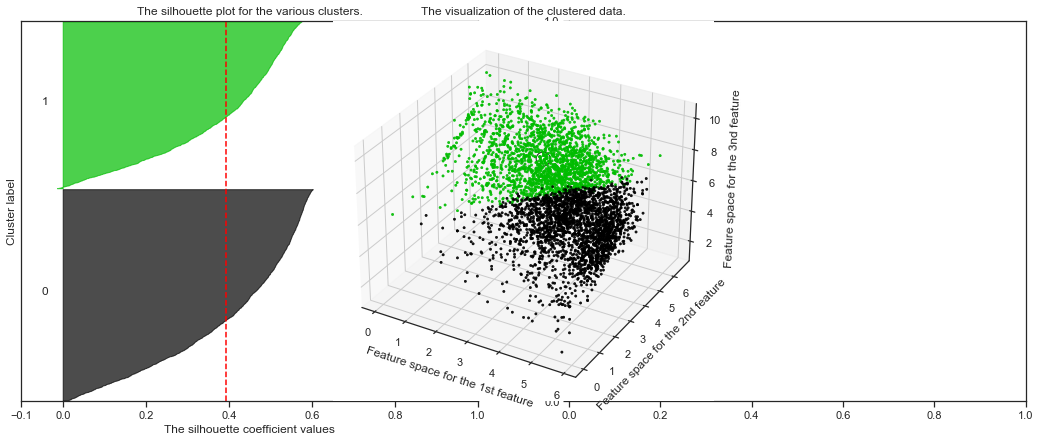

<Figure size 432x288 with 0 Axes>

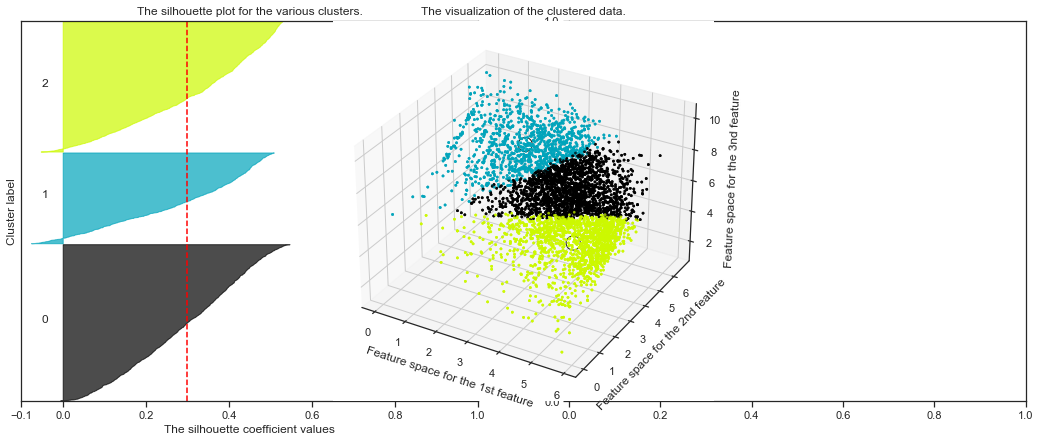

<Figure size 432x288 with 0 Axes>

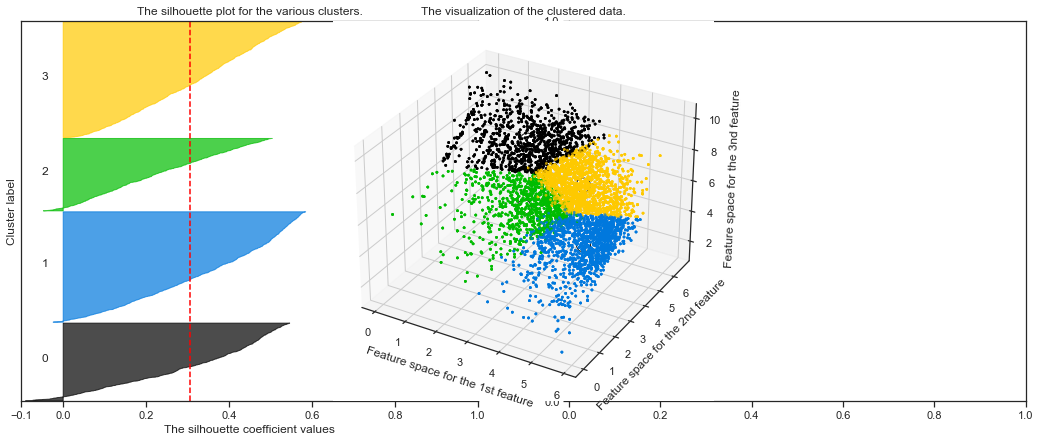

<Figure size 432x288 with 0 Axes>

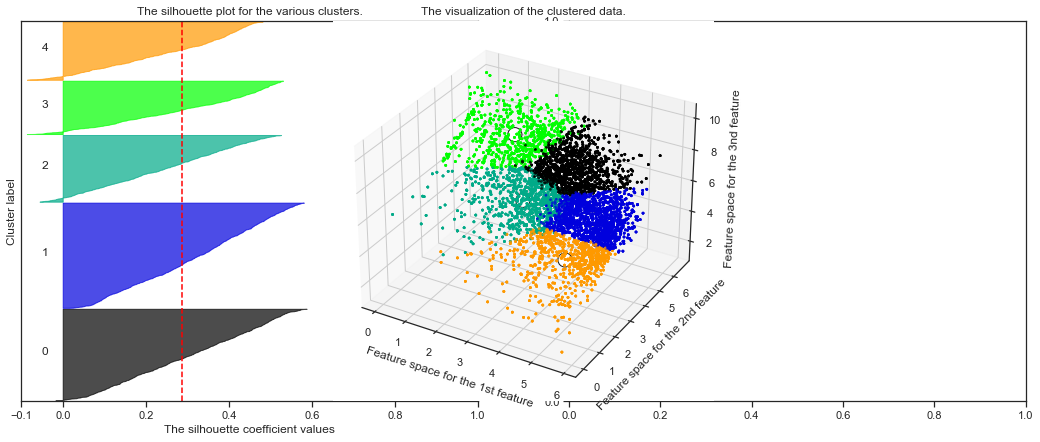

<Figure size 432x288 with 0 Axes>

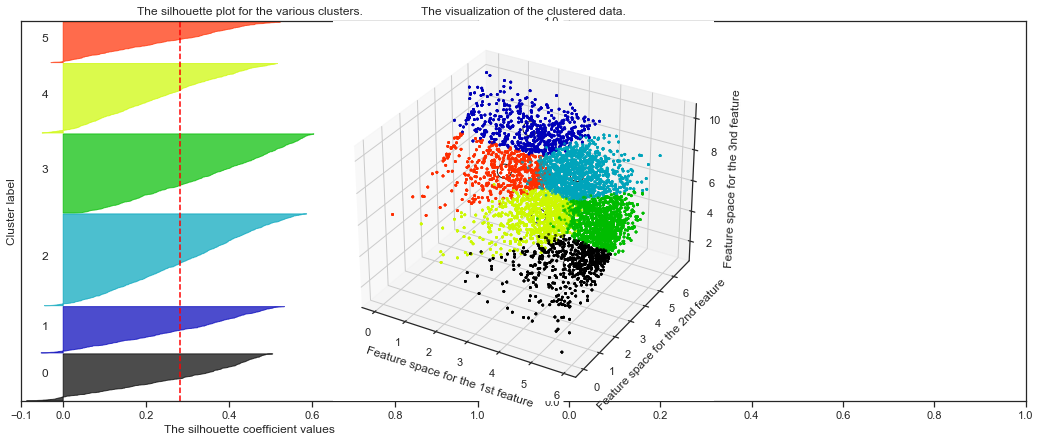

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [56]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample --> hier alle 3 Feature als Array übergeben
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed --> alle 3 labels als Array X übergeben
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    fig_k2 = plt.figure()
    ax2 = fig.add_subplot(111, projection='3d')
    


    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        centers[:, 2],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        #define 3 axes
        x = X[:, 0]
        y = X[:, 1]
        z = X[:, 2]
        ax2.scatter(x,y,z, marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    ax2.set_zlabel("Feature space for the 3nd feature")
    

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In the best case the coefficient should be rectangular. In our case, the plots become sharper as the number of clusters (k) increases. The pointed plot means, that more points are below the average distance and thus close to another cluster. Partly the coefficients show even negative values, which means, that these samples should have been assigned to another cluster.
From this we conclude that kMeans is less suitable for clustering the data. Nevertheless, we will perform a kMeans clustering with k=2 for comparison with hierarchical clustering, as this still achieves the best silhouette score.

## Performing kMeans Clustering
We will use the normalized and standardized dataset for kMeans Clustering. In order to compare the different cluster segments and derive first insights we will visualize their characteristics in a plot. The function **snake_plot** creates a plot, which shows how high the respective values for Recency, Frequency and Monetary Value are in each group.

In [34]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):
    # Transform df_normal as df and add cluster column
    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=df_rfm.index, 
                                       columns=df_rfm.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

### k = 2

In [35]:
#fitting the data
kmeans_k2 = KMeans(n_clusters=2, n_init=10)
kmeans_k2.fit(df_rfm_scaled)

KMeans(n_clusters=2)

In [36]:
#predict cluster and add to dataframe
df_rfm_k2=df_rfm_scaled.copy()
df_rfm_k2['Cluster']=kmeans_k2.predict(df_rfm_scaled)

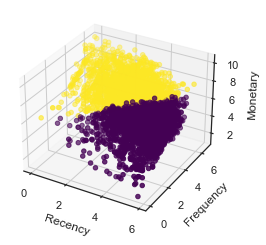

In [57]:
# create 3D-plot
fig_k2 = plt.figure()
ax = fig_k2.add_subplot(111, projection='3d')
#define 3 axes
x = df_rfm_k2['Recency']
y = df_rfm_k2['Frequency']
z = df_rfm_k2['Monetary']

#Labels for axes
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

ax.scatter(x,y,z, c=df_rfm_k2['Cluster'], cmap="viridis")
plt.savefig('kMeans.png')

In [38]:
#Show means and count of each column
df_rfm_k2.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0           5.0       3.0      6.0  2397
1           3.0       5.0      7.0  1891

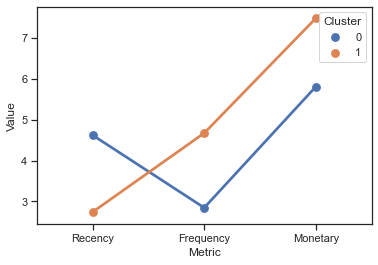

In [39]:
snake_plot(df_rfm_scaled, df_rfm_k2, df_rfm)

The two clusters show differences in the snake and 3D-plot. However, dividing the customers in only 2 groups gives a less detailed picture about the customer base. Also the scatter plot doesn't show a significant difference between those two groups.

# Hierarchical Clustering
Since we are not yet satisfied with the results of the KMeans clustering, we try to see if we can achieve a better result with hierarchical clustering. We will also use the standardizes data *(df_rfm_scaled)* as our basis.

In [40]:
from sklearn.cluster import AgglomerativeClustering

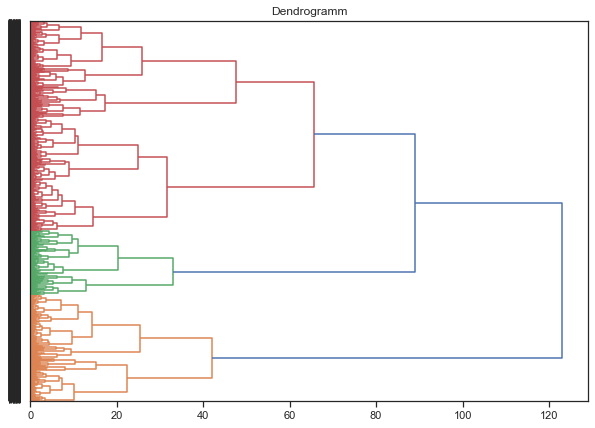

In [54]:
#Dendogramm
from scipy.cluster import hierarchy

plt.figure(figsize=(10, 7))
plt.title("Dendrogramm")

Z = hierarchy.linkage(df_rfm_scaled, 'ward')
dn = hierarchy.dendrogram(Z, labels=df_rfm_scaled.index, orientation='right')
plt.savefig('dendrogram.png')

Hierarchical clustering connects objects that have a smaller distance to each other than to the objects of other clusters. The longer the lines in the dendogram, the more the elements that are merged differ. Therefore, the dendogram suggests a cluster of 3 to 4 clusters, which would already give a more detailed picture about our customer base than the kMeans clustering with k=2.

## n=3

In [42]:
#Define agglomerative cluster algorithm (=bottom-->up)
ward = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=3)
ward.fit(df_rfm_scaled)

AgglomerativeClustering(n_clusters=3)

In [43]:
#apply on dataset and add cluster
df_rfm_h3=df_rfm_scaled.copy()
df_rfm_h3['Cluster']=ward.fit_predict(df_rfm_scaled)

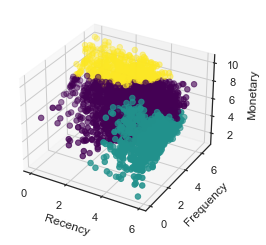

In [58]:
fig_h3 = plt.figure()
ax = fig_h3.add_subplot(111, projection='3d')
#define axes
x = df_rfm_h3['Recency']
y = df_rfm_h3['Frequency']
z = df_rfm_h3['Monetary']

#Labels for axes
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

ax.scatter(x,y,z, c=df_rfm_h3['Cluster'], s=30, cmap="viridis")
plt.savefig('hierarchical.png')

In [45]:
# show mean and count of each cluster
df_rfm_h3.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0           4.0       4.0      7.0  2361
1           5.0       2.0      6.0  1207
2           2.0       5.0      8.0   720

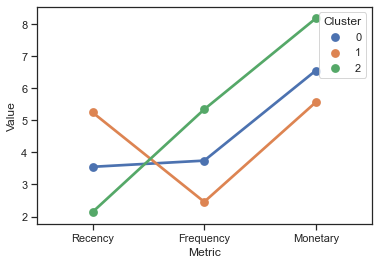

In [46]:
snake_plot(df_rfm_scaled, df_rfm_h3, df_rfm)

The three clusters show different characteristics and differentiate in their means. There differences can also be very well seen in the snake plot. 

## n=4

In [47]:
ward = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=4)
ward.fit(df_rfm_scaled)

AgglomerativeClustering(n_clusters=4)

In [48]:
#perform segmentation
df_rfm_h4=df_rfm_scaled.copy()
df_rfm_h4['Cluster']=ward.fit_predict(df_rfm_scaled)

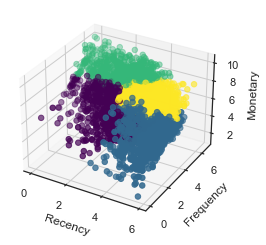

In [49]:
fig_h4 = plt.figure()
ax = fig_h4.add_subplot(111, projection='3d')
#add axes
x = np.array(df_rfm_h4['Recency'])
y = np.array(df_rfm_h4['Frequency'])
z = np.array(df_rfm_h4['Monetary'])

#Labels for axes
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

ax.scatter(x,y,z, c=df_rfm_h4['Cluster'], s=30, cmap="viridis")

In [50]:
df_rfm_h4.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0           3.0       3.0      6.0  1091
1           5.0       2.0      6.0  1207
2           2.0       5.0      8.0   720
3           4.0       4.0      7.0  1270

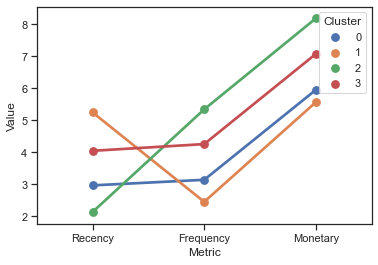

In [51]:
snake_plot(df_rfm_scaled, df_rfm_h4, df_rfm)

The four clusters of the hierarchical clustering (df_rfm_h4) have similar means and a similar distribution over the three categories. This shows, that the clusters are very similar to each other. Therefore, the hierarchical clustering with n=4 is not suitable for the segmentation.

# Conclusion
## Segments

After comparing the different diagrams, we conclude that Hierarchical Clustering with 3 clusters, gives the best results. 
The clusters differ clearly from each other and give a more detailed picture of the customers. The distribution and characteristics of the clusters look realistic:
* **Cluster 2** contains our favorite customers: these are the most recent buyers who buy most often and have spent the most money. Luckily, most of our customers belong to this cluster. The customer value of this segment is **gold**.
* In contrast to that **Cluster 1** represents our least favorite customers: whose last purchase was a long time ago, who bought less often and spent the least money. These are our **bronze** customers.
* **Cluster 0** lies between those two extremes: The last purchase was a little longer ago, but for that they buy relatively regularly and spent moderate money. This segment represents our **silver** cutomers. 

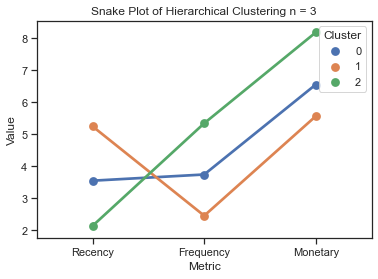

In [52]:
plt.title('Snake Plot of Hierarchical Clustering n = 3')
snake_plot(df_rfm_scaled, df_rfm_h3, df_rfm)
plt.savefig('snake_plot.png')

## Actions

### Gold customers
Gold customers are very valuable to us. Here we should focus on customer loyalty and try to strengthen it (e.g. with individual and regular communication).

### Silver customers
We should try to transform silver customers into gold customers and at the same time avoid them becoming bronze customers. We can support and try to increase their Frequency and Monetary value by giving exclusive offers. 

### Bronze customers
Since these customers hardly contribute to our sales, they have less relevance. However, we could try to encourage them to buy again with retention offers.

# Add Clusterinfo in original dataset

In [92]:
#Set CustomerID as index for merging
df_cluster=df.set_index('CustomerID')

In [118]:
df_cluster.to_csv('Recommender_Marketing.csv', index=True)

In [94]:
df_cluster['Cluster']=df_cluster['Cluster'].astype('category')

In [95]:
#Clusterinfo is missing for some customers as they dropped out in the preprocessing
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 397884 entries, 12346 to 18287
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  category      
 1   StockCode    397884 non-null  category      
 2   Description  397884 non-null  category      
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   Country      397884 non-null  category      
 7   TotalSum     397884 non-null  float64       
 8   Cluster      336802 non-null  category      
dtypes: category(5), datetime64[ns](1), float64(2), int64(1)
memory usage: 17.6 MB


In [96]:
df_cluster[df_cluster['Cluster'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,TotalSum,Cluster
CustomerID,,,,,,,,,
12346,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,United Kingdom,77183.60,NaN
12415,540267,22078,RIBBON REEL LACE DESIGN,120,2011-01-06 11:12:00,1.85,Australia,222.00,NaN
12415,540267,22079,RIBBON REEL HEARTS DESIGN,120,2011-01-06 11:12:00,1.45,Australia,174.00,NaN
12415,540267,22080,RIBBON REEL POLKADOTS,120,2011-01-06 11:12:00,1.45,Australia,174.00,NaN
12415,540267,22077,6 RIBBONS RUSTIC CHARM,144,2011-01-06 11:12:00,1.45,Australia,208.80,NaN
...,...,...,...,...,...,...,...,...,...
18118,579301,22620,4 TRADITIONAL SPINNING TOPS,2,2011-11-29 11:32:00,1.45,United Kingdom,2.90,NaN
18118,579301,22621,TRADITIONAL KNITTING NANCY,3,2011-11-29 11:32:00,1.65,United Kingdom,4.95,NaN
18118,579301,22633,HAND WARMER UNION JACK,1,2011-11-29 11:32:00,2.10,United Kingdom,2.10,NaN


## Export df for recommender

In [93]:
#Add cluster information to original dataset for recommender use case
df_cluster =df_cluster.join(df_rfm_h3).drop(['Recency', 'Frequency', 'Monetary'], axis=1)